# Predicting user churn for Waze

Welcome to this comprehensive report on the Waze project, a machine learning initiative focused on modeling user churn. The primary goal of this project is to provide the Waze leadership with data-driven insights to inform business decisions, improve user retention, and drive business growth.

#### Project Context

As part of my data science portfolio, I have undertaken the task of developing a machine learning model to predict whether a Waze user is likely to churn or be retained. To achieve this, I built and evaluated three tree-based models: a **Decision Tree**, a **Random Forest**, and an **XGBoost**. These models will help identify the key factors that contribute to user churn and allow me to anticipate user behavior more effectively.

#### Project Objectives

The ultimate purpose of this model is to find the factors that drive user churn. The specific goal is to predict whether a Waze user will be retained or will churn. To accomplish this, my work is structured into three main parts:

1. Ethical Considerations

    Evaluate the ethical implications of the request.
    
    Ensure that the benefits of the model outweigh potential problems.

2. Feature Engineering

    Perform feature selection, extraction, and transformation to prepare the data for modeling.

3. Modeling

    Build and evaluate the Decision Tree, Random Forest, and XGBoost models.
    
    Provide recommendations for next steps.

Before proceeding with modeling, I carefully considered the ethical implications of this project, particularly the consequences of model errors.

False Negative (FN): The model predicts a user will not churn, but they do.

Consequence: Waze fails to take proactive measures to retain the user, potentially leading to a loss.

False Positive (FP): The model predicts a user will churn, but they do not.

Consequence: Waze may take unnecessary retention measures, which could annoy loyal users and negatively impact their experience.

Despite these risks, the benefits of such a model are considered to outweigh the potential problems. I will proceed with building the model, with the recommendation that any proactive retention measures be followed up with an analysis of their effectiveness to ensure they do not unintentionally encourage churn.

 # Imports and data loading

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Show all columns when displaying DataFrames
pd.set_option('display.max_columns', None)

# Machine learning models - Decision tress and random forests 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Gradient boosting model with XGBoost
from xgboost import XGBClassifier

# Utility for counting elements
from collections import Counter

# Data splitting and hyperparameter tuning 
from sklearn.model_selection import train_test_split, GridSearchCV

# Model evaluation metrics (from scikit-learn)
from sklearn.metrics import (
    f1_score,               # F1 score
    recall_score,           # Recall
    precision_score,        # Precision
    accuracy_score,         # Accuracy
    confusion_matrix,       # Confusion matrix values
    ConfusionMatrixDisplay, # Visualization of the confusion matrix
    roc_auc_score,          # ROC AUC score
    make_scorer,            # Custom scorer for model evaluation
    roc_curve               # ROC curve values
)

# Feature importance visualization for XGBoost
from xgboost import plot_importance

# Saving and loading Python objects/models
import pickle

In [2]:
# Load the dataset from a CSV file into a Pandas DataFrame
df0 = pd.read_csv('C:/Users/ee391987/OneDrive - UQAM/Perso/LANGAGE/ML/waze_dataset.csv')

In [3]:
# Display the dimensions of the DataFrame as (number of rows, number of columns) 
df0.shape

(14999, 13)

In [4]:
# Display the first 5 rows of the DataFrame
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


# Feature engineering

In this stage, several new features were created to enhance the dataset and potentially improve churn prediction models. The original dataset df0 was preserved, and a working copy df was used. The dataset was used to create new variables that could improve churn prediction, such as average kilometers per driving day, percentage of sessions in the last month, professional driver indicators, average sessions per day since onboarding, average speed, kilometers per drive, and percentage of drives to favorite locations. Infinite values from divisions by zero were replaced with zero, and domain knowledge was applied to define meaningful thresholds, while noting potential data quality issues in some calculated features.

In [5]:
# Copy the df0 dataframe
df = df0.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [7]:
duplicates = df[df.duplicated()]

if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates)

No duplicate rows found.


In [8]:
# # Calculate average kilometers driven per driving day in the last month
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Display basic statistics to check the new feature
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [9]:
# Note: Infinite values appear due to division by zero in 'driving_days'

In [10]:
# Replace infinite values with zero to handle division by zero cases
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Verify that infinite values have been replaced
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [11]:
# Calculate the proportion of total sessions that occurred in the last month
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Display summary statistics to understand the distribution of this feature
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [12]:
# Create a binary feature to identify professional drivers
# Criteria: at least 60 drives and 15+ driving days in the last month
df['professional_driver'] = np.where((df['drives'] >=60) & (df['driving_days']>=15),1,0)
df['professional_driver'].value_counts()

0    12405
1     2594
Name: professional_driver, dtype: int64

In [13]:
# Calculate average number of sessions per day since onboarding
df['total_sessions_per_day'] = df['total_sessions']/df['n_days_after_onboarding']

# Show descriptive statistics for the new feature
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [14]:
# Calculate average kilometers driven per hour in the last month
df['km_per_hour'] = (60* df['driven_km_drives'] / df['duration_minutes_drives'])

# Display descriptive statistics to examine the distribution
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [16]:
# Calculate average kilometers per drive in the last month
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Display summary statistics to inspect the new feature
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [17]:
# Replace infinite values (due to division by zero) with zero
df.loc[df['km_per_drive'] == np.inf,'km_per_drive'] = 0

# Confirm that infinite values have been handled
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [18]:
# Calculate percentage of total sessions directed to favorite places
# Serves as a proxy for percent of drives to favorite locations
df['perent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Display descriptive statistics for this feature
df['perent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: perent_of_sessions_to_favorite, dtype: float64

# Drop missing values

In [19]:
# Drop rows with missing values in the target column 'label' (less than 5%, assumed missing at random)
df = df.dropna(subset=['label']).copy()

The target variable `label` is imbalanced, with 11,763 (82%) users retained and 2,536 (18%) users who churned. This class distribution will be important to consider when choosing evaluation metrics and modeling strategies.

# Variable encoding

##### Categorical Features

Since the `device` feature is categorical and only has two categories, it can be directly converted into a numeric binary format for modeling.

In [20]:
## Encode 'device' as binary: Android=0, iPhone=1
df['device2'] = df['device'].map({'Android':0, 'iPhone':1})

# Check the new binary device encoding
df[['device','device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


The target variable `label` is categorical ("retained" or "churned"). To train classification models, convert it to binary numeric form. Assign 0 for retained users and 1 for churned users, storing this in a new column `label2` to keep the original intact.

In [21]:
#  Convert target 'label' to binary: churned=1, retained=0
df['label2'] = df['label'].map({'retained':0, 'churned':1})

# Verify the binary target variable
df[['label','label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14299 entries, 0 to 14998
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14299 non-null  int64  
 1   label                           14299 non-null  object 
 2   sessions                        14299 non-null  int64  
 3   drives                          14299 non-null  int64  
 4   total_sessions                  14299 non-null  float64
 5   n_days_after_onboarding         14299 non-null  int64  
 6   total_navigations_fav1          14299 non-null  int64  
 7   total_navigations_fav2          14299 non-null  int64  
 8   driven_km_drives                14299 non-null  float64
 9   duration_minutes_drives         14299 non-null  float64
 10  activity_days                   14299 non-null  int64  
 11  driving_days                    14299 non-null  int64  
 12  device                          

In [23]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,perent_of_sessions_to_favorite,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0,0.106009,123.147688,8.749890,0.000000,1,0
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0,0.657570,433.471306,2624.586414,0.857534,1,0
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0,0.058711,191.944326,225.487213,0.000000,1,0
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0,0.432859,99.791944,57.645864,0.141665,0,0
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0,0.081682,154.838864,88.874416,0.294115,1,1


# Feature selection

The `ID` column is just an identifier and does not carry predictive information, so it should be removed. Additionally, since `label` (the target) and `device` (categorical) have been converted into numeric variables (`label2` and `device2`), the original `label` and `device` columns should be dropped to avoid redundancy in the modeling data.

In [24]:
df = df.drop(['ID'], axis=1)


### **Evaluation Metrics and Class Imbalance**

Before delving into the modeling process, it's crucial to select the most appropriate evaluation metric. This decision hinges on two key factors: the class balance of our target variable and the specific business use case of the model.

---

### **Analyzing Class Imbalance**

I first examined the distribution of our target variable, `label`, to understand the balance between the user classes.

* **Retained Users**: Approximately **82%**
* **Churned Users**: Approximately **18%**

With 18% of users having churned, our dataset exhibits a **moderate class imbalance**. While this imbalance is not severe enough to require advanced rebalancing techniques (like SMOTE), it's a critical consideration for metric selection. Relying solely on **accuracy** would be misleading; a naive model that always predicts the majority class could achieve a high accuracy of 82% without ever identifying a single user at risk of churning.

---

### **Selecting the Optimal Evaluation Metric**

The choice of metric must align with the business objective and the consequences of model errors. In this project, it was determined that the risk associated with a **false positive** prediction (the model predicts a user will churn, but they won't) is minimal. A loyal user might receive an unnecessary retention offer, but this carries no significant negative consequences.

In contrast, a **false negative** prediction (the model predicts a user will not churn, but they do) has a direct and tangible business impact: Waze misses a crucial opportunity to retain a customer. To maximize the detection of all users who are likely to churn, it is imperative to prioritize **recall**.

Therefore, the primary metric for evaluating and selecting the best model will be **recall**. A high recall score will ensure that we identify the largest possible proportion of at-risk users, enabling Waze to implement targeted and effective retention strategies.

In [25]:
df['label2'].value_counts(normalize=True)

0    0.822645
1    0.177355
Name: label2, dtype: float64

# Data splitting

The final modeling dataset includes 14,299 samples, which is on the lower side but still adequate for robust model selection. The data will be split into training, validation, and test sets using a 60/20/20 ratio. This ensures approximately 8,579 samples for training, and about 2,860 samples each for validation and testing.

Special attention is given to the minority class (churned users), which represents around 18% of the data. This means roughly 515 churn cases will be present in both validation and test sets, providing enough examples to fairly evaluate model performance.

The workflow consists of fitting and tuning models on the training set, selecting the best model using the validation set, and finally assessing the chosen model’s performance on the test set.

In [26]:
# Prepare features and target, drop original label and device categorical columns
X = df.drop(columns=['label', 'label2', 'device'])
y = df['label2']

# First split: separate out the test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, train_size=0.2, stratify=y, random_state=42)

# Second split: split remaining 80% into train (60%) and validation (20%)
# Since X_temp is 80%, train size should be 0.75 to get 60% of total data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, train_size=0.25, stratify=y_temp, random_state=42)

# Modeling

In [27]:
# list of scoring metrics to capture
scoring = {
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'accuracy': make_scorer(accuracy_score)
}


def write_pickle(path, model_object, save_as:str):
    '''
    Save a model object to disk as a pickle file.
    
    Args:
        path (str): Folder path where to save the pickle.
        model_object: The model to be saved.
        save_as (str): Filename (without extension) to save the model as.
    
    Returns:
        None. The model is saved as a .pickle file.
    '''
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
        

def read_pickle(path, saved_model_name:str):
    '''
    Load a pickled model object from disk.
    
    Args:
        path (str): Folder path where the pickle is stored.
        saved_model_name (str): Filename (without extension) of the pickled model.
        
    Returns:
        The loaded model object.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model


# Example path where models will be saved or loaded from
path = 'C:/Users/ee391987/OneDrive - UQAM/Perso/LANGAGE/ML/'


def make_results(model_name:str, model_object, metric:str):
    '''
    Generate a summary table of model performance metrics from a GridSearchCV object.
    
    Args:
        model_name (str): Name to assign to the model in the output table.
        model_object: Fitted GridSearchCV object containing cross-validation results.
        metric (str): The metric used to select the best model ('precision', 'recall', 'f1', or 'accuracy').
    
    Returns:
        pandas.DataFrame: Table with model name and its precision, recall, F1, and accuracy scores,
                          based on the best mean score for the chosen metric across validation folds.
    '''
    # Mapping input metric to GridSearchCV result column names
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'}

    # Extract all CV results into a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Find the row with the best mean score for the chosen metric
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract relevant performance metrics from the best row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Build a results DataFrame
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]})

    return table


## Decision Tree

In [28]:
# Define hyperparameter grid to tune Decision Tree model
dt_cv_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}


# Instantiate a Decision Tree classifier with balanced class weights for imbalanced data
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Set up GridSearchCV to perform hyperparameter tuning with 5-fold cross-validation,
# optimizing for ROC AUC score and using the specified scoring metrics
dt_cv = GridSearchCV( estimator = dt, param_grid = dt_cv_params, scoring= scoring, cv = 5, refit= 'recall')


In [28]:
%%time
dt_cv.fit(X_train, y_train)

CPU times: total: 6.86 s
Wall time: 6.95 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [10, 20, 50]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, zero_division=0),
                      'precision': make_scorer(precision_score, zero_division=0),
                      'recall': make_scorer(recall_score, zero_division=0)})

In [29]:
# Save the trained GridSearchCV object to disk
#write_pickle(path, dt_cv, 'results_dt_cv')
#  Load the saved GridSearchCV object from disk
dt_cv = read_pickle(path, 'results_dt_cv')

# Display the best hyperparameters found by GridSearchCV
dt_cv.best_params_

{'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [30]:
# Generate a summary table of performance metrics for the Decision Tree model using recall as the selection metric
dt_cv_results = make_results('Decision Tree CV', dt_cv, 'recall')

# Copy the results for further use or comparison
results = dt_cv_results.copy()

## Random forest

In [33]:
# Define hyperparameter grid for tuning the Random Forest model
rf_cv_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 30, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Instantiate a Random Forest classifier with balanced class weights for imbalanced data
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Set up GridSearchCV for hyperparameter tuning with 5-fold CV,
# optimizing for recall and using the provided scoring dictionary
rf_cv = GridSearchCV(estimator=rf, param_grid=rf_cv_params, scoring=scoring, cv=5, refit='recall')

In [34]:
%%time
# Fit the Random Forest model with hyperparameter tuning (timing the operation)
rf_cv.fit(X_train, y_train)

CPU times: total: 24min 40s
Wall time: 25min 11s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [10, 30, 50],
                         'n_estimators': [100, 200, 300]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, zero_division=0),
                      'precision': make_scorer(precision_score, zero_division=0),
                      'recall': make_scorer(recall_score, zero_division=0)})

In [35]:
# Save the trained GridSearchCV object (uncomment to save)
#write_pickle(path, rf_cv, 'results_rf_cv')
# Load the saved GridSearchCV object from disk
rf_cv = read_pickle(path, 'results_rf_cv')

# Display the best hyperparameters found during tuning
rf_cv.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 20,
 'min_samples_split': 50,
 'n_estimators': 100}

In [36]:
# Generate performance summary table using ROC AUC as selection metric
rf_cv_results = make_results('Random Forest CV', rf_cv, 'recall')

## XGBoost

In [39]:
# Define hyperparameter grid for tuning XGBoost classifier
xgb_cv_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 6],
    'min_child_weight': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 2]
}

# Calculate scale_pos_weight to handle class imbalance based on training labels
counter = Counter(y_train)
scale_pos_weigh = counter[0] / counter[1]

# Instantiate XGBoost classifier with computed scale_pos_weight and fixed random state
xgb = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weigh)

# Setup GridSearchCV for hyperparameter tuning with 5-fold CV,
# optimizing for recall and using the scoring dictionary
xgb_cv = GridSearchCV(estimator=xgb, param_grid=xgb_cv_params, scoring=scoring, cv=5, refit='recall')

In [40]:
%%time
# Fit the model with hyperparameter tuning (timed)
xgb_cv.fit(X_train, y_train)

write_pickle(path, xgb_cv, 'results_xgb_cv')

CPU times: total: 1d 4h 43min 45s
Wall time: 4h 9min 28s


In [41]:
# Save the trained GridSearchCV object (uncomment to save)
# write_pickle(path, xgb_cv, 'results_xgb_cv')

# Load the saved GridSearchCV object from disk
xgb_cv = read_pickle(path, 'results_xgb_cv')

# Display the best hyperparameters found during tuning
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.6}

In [42]:
# Generate performance summary table using recall as selection metric
xgb_cv_results = make_results('XGBoost CV', xgb_cv, 'recall')


In [43]:
# Combine the cross-validation results of Decision Tree, Random Forest, and XGBoost models into a single DataFrame for easy comparison
results = pd.concat([dt_cv_results, rf_cv_results, xgb_cv_results], axis=0)

# Display the combined results table
results


,model,precision,recall,F1,accuracy
0,Decision Tree CV,0.323186,0.739692,0.449268,0.676411
0,Random Forest CV,0.363739,0.724923,0.483994,0.725441
0,XGBoost CV,0.375066,0.755692,0.500729,0.731045


**Based on the cross-validation results, here’s how the three models compare:**

The **XGBoost** model stands out as the top performer. It achieves the best F1 score (0.50), which is important because it balances precision and recall. It also has the highest accuracy (0.73) and recall (0.76), meaning it’s the most effective at correctly identifying positive cases while still being fairly accurate overall.

The **Random Forest** model comes in second. Its F1 score (0.48) and accuracy (0.73) are just slightly lower than XGBoost’s, and it has better precision than the Decision Tree, which means it makes fewer false positive predictions.

The **Decision Tree** model is the weakest of the three. While its recall (0.74) is still good, its low precision (0.32) means it flags a lot of negatives as positives, which hurts its reliability.

**Key points to note:**

* All three models have strong recall, so they’re good at finding the positives.
* Precision is a weakness across the board, none of them go above 0.38. This means they tend to overpredict positives, which could lead to many false alarms.
* Since these are training-stage cross-validation results, the next step would be to tune the models (e.g., adjust class weights or thresholds) to improve precision without losing too much recall.


# Model selection 

In [44]:
def get_test_scores(model_name:str, model_object, X_test_data, y_test_data, plot_roc =True, return_table = True):
    '''
    Evaluate a trained model on test data and optionally plot ROC curve.

    Inputs:
        model_name (str): Name of the model to display in output.
        model_object: Trained model object (expects a GridSearchCV or RandomizedSearchCV with best_estimator_).
        X_test_data (array-like): Feature matrix for the test set.
        y_test_data (array-like): True labels for the test set.
        plot_roc (bool): Whether to plot the ROC curve. Default is True.
        return_table (bool): Whether to return a pandas DataFrame with metrics. Default is True.

    Outputs:
        If return_table is True, returns a DataFrame containing precision, recall, F1 score, accuracy, and ROC AUC.
        Also plots the ROC curve if plot_roc is True.
    '''
    preds = model_object.best_estimator_.predict(X_test_data)
    proba = model_object.best_estimator_.predict_proba(X_test_data)[:,1]
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    rocauc =  roc_auc_score(y_test_data, proba)
    
    if plot_roc :
        fpr, tpr, _ = roc_curve(y_test_data, proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {rocauc:.2f})', color='darkorange')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
    
    if return_table :
        table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'roc_auc': [rocauc]
                          })
        return table


In [45]:
# Evaluate Decision Tree on validation set without plotting ROC curve and store metrics
dt_val_results = get_test_scores('Decision Tree val', dt_cv, X_val, y_val, plot_roc=False, return_table=True)

# Evaluate Random Forest on validation set without plotting ROC curve and store metrics
rf_val_results = get_test_scores('Random Forest val', rf_cv, X_val, y_val, plot_roc=False, return_table=True)

# Evaluate XGBoost on validation set without plotting ROC curve and store metrics
xgb_val_results = get_test_scores('XGBoost val', xgb_cv, X_val, y_val, plot_roc=False, return_table=True)

# Combine validation performance metrics of Decision Tree, Random Forest, and XGBoost models into a single DataFrame for comparison
results_val = pd.concat([dt_val_results, rf_val_results, xgb_val_results], axis=0)

# Display the combined validation results table
results_val


,model,precision,recall,F1,accuracy,roc_auc
0,Decision Tree val,0.296774,0.726316,0.421374,0.646620,0.685442
0,Random Forest val,0.338028,0.631579,0.440367,0.715618,0.734719
0,XGBoost val,0.333333,0.655263,0.441881,0.706760,0.736654


Based on the validation data, XGBoost and Random Forest are the strongest performers. XGBoost has the highest F1 score (0.44), while Random Forest has slightly better accuracy (0.72) and precision (0.34). Both models show good generalization, with ROC AUC scores above 0.73. The Decision Tree is the weakest model, with poor precision (0.30) and the lowest overall F1 score (0.42) and accuracy (0.65).

A key finding is that all models have higher recall than precision, indicating they are effective at identifying positive cases but tend to generate a high number of false alarms.

Next steps include selecting either XGBoost or Random Forest and optimizing its prediction threshold on the validation set to improve the balance between precision and recall, before evaluating the final performance on the test set.

In [46]:
def get_compromise_scores(model_name:str, model_object, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (str): Name for the model in the output table.
        model_object: Trained model (with best_estimator_ if using GridSearchCV).
        X_test_data (array-like): Test features.
        y_test_data (array-like): True test labels.

    Out:
        table (pd.DataFrame): Table with precision, recall, f1, accuracy, and ROC AUC scores.
    '''
    
    preds = model_object.best_estimator_.predict(X_test_data)
    proba = model_object.best_estimator_.predict_proba(X_test_data)[:,1]
    
    seuils = np.linspace(0.1, 0.9, 50)
    best_seuil = 0.5
    best_f1 = 0

    for s in seuils:
        preds_temp = (proba >= s).astype(int)
        f1 = f1_score(y_test_data, preds_temp)
        if f1 > best_f1:
            best_f1 = f1
            best_seuil = s

    # Apply the best threshold
    final_preds = (proba >= best_seuil).astype(int)
     
    accuracy = accuracy_score(y_test_data, final_preds)
    precision = precision_score(y_test_data, final_preds)
    recall = recall_score(y_test_data, final_preds)
    f1 = f1_score(y_test_data, final_preds)
    rocauc =  roc_auc_score(y_test_data, proba)
    
    table = pd.DataFrame({'model': [model_name],
                          'thresh_optimal': [best_seuil],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'roc_auc': [rocauc]
                          })
    return table

In [48]:
dt_seuil = get_compromise_scores('Decision Tree ', dt_cv, X_val, y_val)
rf_seuil = get_compromise_scores('Random Forest ', rf_cv, X_val, y_val)
xgb_seuil = get_compromise_scores('XGBoost ', xgb_cv, X_val, y_val)

results_thresh = pd.concat([dt_seuil, rf_seuil, xgb_seuil], axis=0)
results_thresh

,model,thresh_optimal,precision,recall,F1,accuracy,roc_auc
0,Decision Tree,0.442857,0.296774,0.726316,0.421374,0.646620,0.685442
0,Random Forest,0.524490,0.354232,0.594737,0.444008,0.736131,0.734719
0,XGBoost,0.491837,0.331646,0.689474,0.447863,0.698834,0.736654


Based on the validation results with optimized thresholds, the Decision Tree identifies a high proportion of users likely to churn, reflected in its high recall of 0.73. However, its low precision of 0.30 indicates many false positives, making it less reliable overall. Random Forest provides a better balance between precision and recall, achieving a higher F1-score of 0.44 and strong accuracy of 0.74, suggesting it can more reliably predict at-risk users while minimizing false alerts. XGBoost achieves the highest F1-score at 0.45 and maintains a high recall of 0.69, making it the most effective model at detecting potential churn while keeping false positives reasonable. These results indicate that optimizing the prediction threshold significantly improves the trade-off between precision and recall. Overall, XGBoost appears to be the most suitable model for anticipating user churn and informing retention strategies, with Random Forest as a close alternative. The Decision Tree, while simpler and more interpretable, is less effective due to its lower precision.

In [55]:
#final_table = pd.concat([results, results_val])
#final_table
#get_test_scores('Decision Tree val', dt_cv, X_val, y_val, plot_roc=True, return_table=False)
#get_test_scores('Random Forest val', rf_cv, X_val, y_val, plot_roc=True, return_table=False)
#get_test_scores('XGBoost val', xgb_cv, X_val, y_val, plot_roc=True, return_table=False)

# Test 

In [49]:
#xgb_test_results = get_test_scores('XGBoost test', xgb_cv, X_test, y_test, plot_roc =False, return_table = True)

model_name = 'XGBoost test'

xgb_thresh = 0.491837
y_pred = xgb_cv.best_estimator_.predict(X_test)
y_proba = xgb_cv.best_estimator_.predict_proba(X_test)[:,1]
y_preds_thresh = (y_proba >= xgb_thresh).astype(int)


accuracy = accuracy_score(y_test, y_preds_thresh)
precision = precision_score(y_test, y_preds_thresh)
recall = recall_score(y_test, y_preds_thresh)
f1 = f1_score(y_test, y_preds_thresh)
rocauc =  roc_auc_score(y_test, y_proba)

xgb_test_results = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'roc_auc': [rocauc]
                          })

In [50]:
xgb_test_results

,model,precision,recall,F1,accuracy,roc_auc
0,XGBoost test,0.310541,0.644653,0.419164,0.683129,0.727458


The XGBoost model with the optimized threshold is the most effective for predicting Waze user churn. It successfully identifies a large portion of users likely to churn (high recall) while maintaining a reasonable balance with precision. Although precision is moderate, the model provides a reliable tool for detecting at-risk users, enabling targeted retention strategies. Threshold optimization on the validation set maximized the model’s effectiveness before final evaluation on the test set, confirming its robustness and ability to generalize to unseen data.

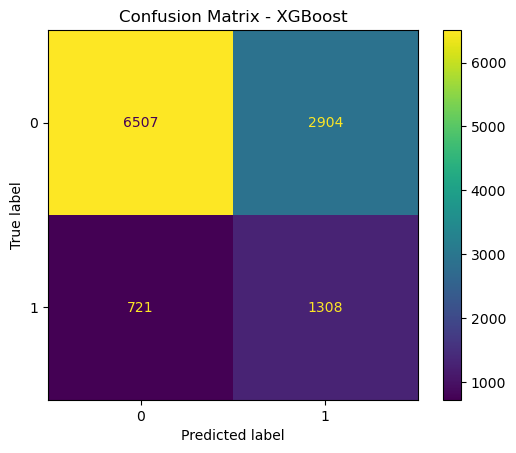

In [51]:
# Create the display for your confusion matrix.

cm = confusion_matrix(y_test, y_preds_thresh)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

The confusion matrix for XGBoost on the test set highlights the model’s performance in classifying Waze users. Out of all non-churning users, 6,507 were correctly identified (true negatives), while 2,904 were incorrectly predicted as churners (false positives). Among the actual churners, 1,308 were correctly detected (true positives), and 721 were missed (false negatives).

This confirms the earlier observations from the metrics: the model achieves a relatively high recall (0.64), meaning it successfully identifies a large portion of users likely to churn. However, the precision remains moderate (0.31), indicating a substantial number of false positives. Overall, XGBoost provides a reliable tool for detecting at-risk users, striking a practical balance between capturing churn cases and controlling false alerts, which is essential for designing targeted retention strategies.

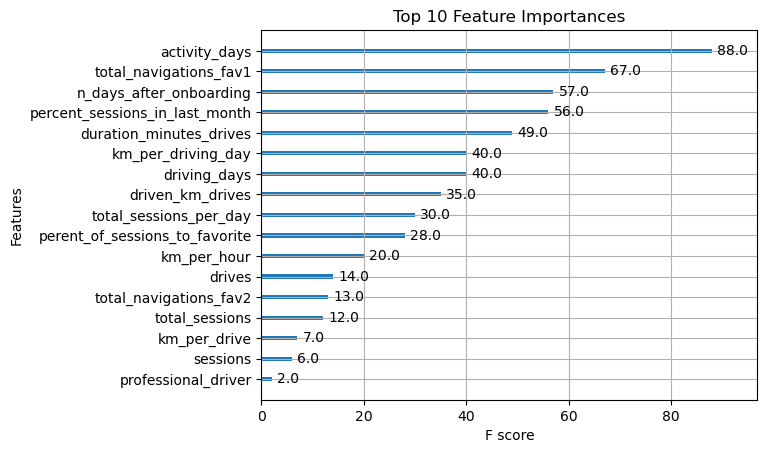

In [53]:
# Plot the relative feature importance of the predictor variables in the model.

plot_importance(xgb_cv.best_estimator_, importance_type='weight')
plt.title("Top 10 Feature Importances")
plt.show()


### **Analysis of Feature Importance**

The provided data shows the relative importance of different features in the XGBoost model, which are known for their ability to rank features. The higher the score, the more impact a feature has on the model's predictions.

1.  **Top Predictors:** The most important features are **activity\_days (88.0)**, **total\_navigations\_fav1 (67.0)**, and **n\_days\_after\_onboarding (57.0)**. These are the primary drivers for the model's output. This suggests that the duration of a user's activity, their engagement with a specific type of navigation, and how long they have been a user are the most critical factors.

2.  **Mid-tier Predictors:** Features like **percent\_sessions\_in\_lats\_moonth (56.0)**, **duration\_minutes\_drives (49.0)**, **km\_per\_driving\_day (40.0)**, and **driving\_days (40.0)** also play a significant role. These features are related to the intensity and recency of a user's driving behavior.

3.  **Low-impact Predictors:** Features such as **km\_per\_drive (7.0)**, **sessions (6.0)**, and **professional\_driver (2.0)** have very little influence on the model's predictions. This is an important finding, as it suggests these variables do not provide much predictive power, and you might consider removing them to simplify the model without a significant loss in performance. The fact that `professional_driver` has such a low score is particularly interesting, as one might expect it to be a key factor.

### **Key Takeaways**

The model heavily relies on **user activity and engagement metrics**, particularly those related to the duration and type of navigation. The number of days a user has been active and the recency of their sessions are far more predictive than the total number of sessions or the average length of a drive. The low importance of `professional_driver` suggests that driving patterns might not differ significantly between professional and non-professional users in a way that is useful for this model.